# Predicting Discharge Reference Capacity using Voltage Rebound Information 

**NOTE**: Using parameters estimated from a logisitic-like function fit on the rebound curve, as well as max measured temp in celsius.

**NOTE**: This analysis does not take into account a cell's cycle history, therefore time is not a predictor and is not considered in this analysis.

**NOTE**: Definitions for logisitc-like estimated parameters:
  
*  L: Asymptotic maximum value  
*  A: Scaling factor  
*  x0: Midpoint of the curve  
*  b: Growth rate  

In [1]:
# load packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
n45_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa45_WORSTsubset180.csv')
n47_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa47_WORSTsubset180.csv')
n48_sub = pd.read_csv('C:/Users/Worm/Downloads/New_NASA_Rebound/nasa48_WORSTsubset180.csv')

In [3]:
n_all = pd.concat([n45_sub, n47_sub, n48_sub], axis = 0)

In [4]:
print(n_all.shape)

(207, 8)


In [5]:
n_all.head()

Step         L         A         x0         b  Reference Capacity  \
0   0.0  3.606426  1.616955  14.075012  0.845795            4356.636   
1   4.0  3.561561  1.575158  12.097068  0.974620            3856.567   
2   6.0  3.550482  1.563146  11.167523  1.038587            3703.252   
3   8.0  3.550897  1.582597  10.995562  1.035746            3594.173   
4  10.0  3.560469  1.578157  10.825082  1.013183            3506.276   

   Max_Temp  Ambient_Temperature  
0    15.710                  4.0  
1    16.327                  4.0  
2    16.190                  4.0  
3    16.445                  4.0  
4    16.652                  4.0

In [6]:
n_all = n_all.drop(columns = ['Ambient_Temperature', 'Step', 'Max_Temp'])

In [7]:
n_all.isnull().sum()

L                     0
A                     0
x0                    0
b                     0
Reference Capacity    0
dtype: int64

In [8]:
n_all = n_all.dropna()

In [9]:
n_all.duplicated().any()

False

In [10]:
n_all.head()

L         A         x0         b  Reference Capacity
0  3.606426  1.616955  14.075012  0.845795            4356.636
1  3.561561  1.575158  12.097068  0.974620            3856.567
2  3.550482  1.563146  11.167523  1.038587            3703.252
3  3.550897  1.582597  10.995562  1.035746            3594.173
4  3.560469  1.578157  10.825082  1.013183            3506.276

In [11]:
n_all.tail()

L         A         x0         b  Reference Capacity
63  4.053143  1.367157  90.792453  0.425636            4679.544
64  3.761847  1.062848  29.368878  0.507540            4568.834
65  3.198999  0.508999   0.308223  5.962126            4519.852
66  3.190154  0.506154   7.791413  3.232986            4507.155
67  3.207044  0.517044   7.870066  3.238898            4403.258

In [12]:
n_all.describe()

L           A          x0           b  Reference Capacity
count  207.000000  207.000000  207.000000  207.000000          207.000000
mean     3.872125    1.490329   55.359353    0.656400         4099.555184
std      0.257534    0.210632   46.638983    0.522903          867.215342
min      3.190154    0.506154    0.308223    0.323078         2678.509000
25%      3.627969    1.438081   12.079069    0.395531         3127.438500
50%      3.909619    1.543493   44.939184    0.452477         4359.665000
75%      4.118833    1.637373   84.433702    0.935130         4654.944500
max      4.301596    1.713641  187.354719    5.962126         6134.145000

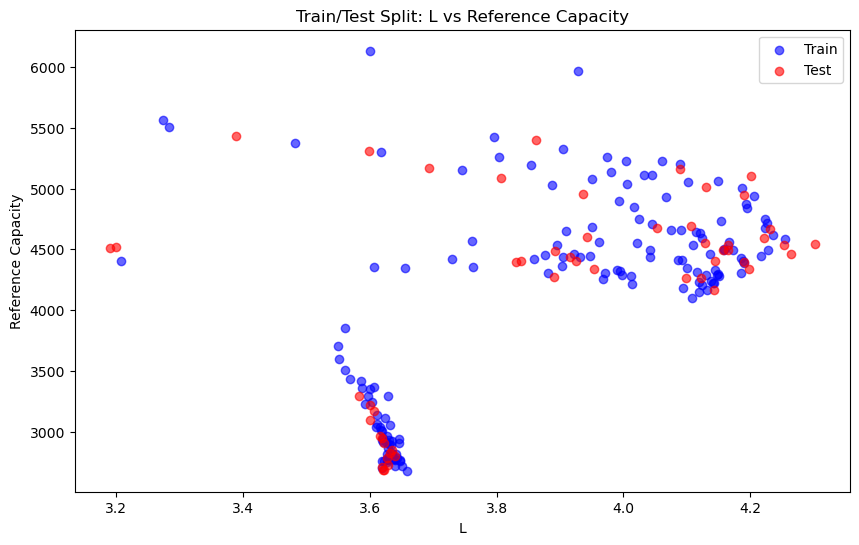

In [13]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define features (X) and target (y)
y = n_all["Reference Capacity"]  # Target
X = n_all.drop('Reference Capacity', axis = 1) # Features

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot training points in blue
plt.scatter(X_train['L'], y_train, color="blue", label="Train", alpha=0.6)

# Plot testing points in red
plt.scatter(X_test['L'], y_test, color="red", label="Test", alpha=0.6)

# Add labels, legend, and title
plt.xlabel("L")
plt.ylabel("Reference Capacity")
plt.title("Train/Test Split: L vs Reference Capacity")
plt.legend()
plt.show()

In [14]:
print(X_train.shape, y_train.shape)
print('\n', X_test.shape, y_test.shape)

(155, 4) (155,)

 (52, 4) (52,)


In [15]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Polynomial Degree 2": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Linear Regression
  RMSE (folds): [360.82781776906285, 344.2871368296718, 2427.653055729935, 368.320176508963, 374.17014490283185]
  MAE (folds): [268.0864887328463, 279.71072769419544, 634.1465931559039, 288.4249965802911, 250.5763735671172]
  Average RMSE: 775.0517
  Average MAE: 344.1890
--------------------------------------------------
Evaluating: Ridge Regression
  RMSE (folds): [361.21052325702027, 343.91607535636024, 1515.478871629009, 369.50108845918044, 371.2796131737618]
  MAE (folds): [268.78780989820655, 281.18674645568933, 478.9372759527416, 289.310595525162, 251.15589124751932]
  Average RMSE: 592.2772
  Average MAE: 313.8757
--------------------------------------------------
Evaluating: Lasso Regression
  RMSE (folds): [360.8326790051516, 344.2911568237058, 2412.7546169184425, 368.3520119267792, 374.1211380408215]
  MAE (folds): [268.0917828210786, 279.7383981495905, 630.600359850322, 288.45014159518826, 250.58785022544126]
  Average RMSE: 772.0703
  Average

In [17]:
models.keys()

dict_keys(['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Polynomial Degree 2'])

In [18]:
models['Elastic Net'].coef_

array([  88.8135099 , -539.18760625,  161.89849296, -346.25223977])

In [19]:
models['Elastic Net'].intercept_

4086.6244200003066

In [20]:
X_train_scaled

array([[-9.51746424e-01,  7.14756229e-01, -9.59246860e-01,
         7.77118636e-01],
       [-9.97765874e-01,  6.86974453e-01, -9.67220697e-01,
         9.85262447e-01],
       [-9.73717251e-01,  8.28443644e-01, -9.32788043e-01,
         1.02544770e+00],
       [ 8.29281955e-01,  5.04357964e-01,  3.77190875e-01,
        -6.83864786e-01],
       [ 1.28927223e+00,  2.03985611e-02,  1.46438990e+00,
        -7.01331543e-01],
       [ 1.36121395e+00,  1.34598512e-01,  2.31917400e+00,
        -8.04664844e-01],
       [-1.21935378e+00,  4.68652608e-01, -9.73168441e-01,
         1.11561792e+00],
       [ 5.81687400e-01,  8.90299501e-02, -2.07033052e-02,
        -5.24391607e-01],
       [-9.50606615e-01,  7.48068237e-01, -9.39247221e-01,
         9.74598906e-01],
       [ 5.76473189e-01,  1.08524012e-01, -1.48070244e-02,
        -5.40713114e-01],
       [ 1.08836114e+00,  7.71976818e-01,  5.02641575e-01,
        -6.23479597e-01],
       [ 8.88188066e-01, -5.20438030e-01,  1.63516142e+00,
      

In [21]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Models to evaluate
models = {
    "SVM with RBF Kernel": SVR(kernel='rbf'),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, X, y):
    rmse_scores = []
    mae_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Evaluate the model
    rmse_scores, mae_scores = evaluate_model(model, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: SVM with RBF Kernel
  RMSE (folds): [804.5748127320588, 935.2501999479723, 843.1868758892815, 947.706731374772, 881.8909087671674]
  MAE (folds): [599.0396695328496, 736.2574223104765, 654.6494297855925, 743.67571622684, 713.1295350258231]
  Average RMSE: 882.5219
  Average MAE: 689.3504
--------------------------------------------------
Evaluating: Decision Tree
  RMSE (folds): [202.18949991179235, 455.005279666426, 276.1114388633576, 195.5602843487928, 353.68326710969393]
  MAE (folds): [145.9963870967742, 255.69458064516132, 172.45287096774203, 118.35419354838723, 209.308935483871]
  Average RMSE: 296.5100
  Average MAE: 180.3614
--------------------------------------------------
Evaluating: Random Forest
  RMSE (folds): [180.75383198733178, 217.26602782334922, 251.35354462402086, 255.8882416428955, 368.4187225002231]
  MAE (folds): [106.67247161290271, 135.96929612903162, 185.20982419354843, 138.4611893548397, 191.27898677419398]
  Average RMSE: 254.7361
  Average MAE: 

In [22]:
from sklearn.model_selection import GridSearchCV
import joblib  # To save the model

# Models to evaluate
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Hyperparameter grids
param_grids = {

    "Decision Tree": {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics
def evaluate_model(model, param_grid, X, y):
    rmse_scores = []
    mae_scores = []
    
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_  # Get the best model from GridSearchCV
    print(f"Best parameters for {model}: {grid_search.best_params_}")
    
    # Save the best model for Random Forest
    if isinstance(best_model, RandomForestRegressor):
        joblib.dump(best_model, 'best_random_forest_model.joblib')
        print("Best Random Forest model saved as 'best_random_forest_model.joblib'")

    # Save the best model for Decision Tree
    if isinstance(best_model, DecisionTreeRegressor):
        joblib.dump(best_model, 'best_decision_tree_model.joblib')
        print("Best Decision Tree model saved as 'best_decision_tree_model.joblib'")
    
    # Evaluate the best model using cross-validation
    for train_idx, val_idx in kf.split(X):
        # Split data into training and validation for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Fit the model
        best_model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = best_model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Return scores
    return rmse_scores, mae_scores

# Convert data to numpy arrays for consistent indexing (X should be 2D)
y_train_np = y_train.to_numpy()

# Evaluate models
for name, model in models.items():
    print(f"Evaluating: {name}")
    
    # Get the hyperparameter grid for the model
    param_grid = param_grids[name]
    
    # Evaluate the model with hyperparameter tuning
    rmse_scores, mae_scores = evaluate_model(model, param_grid, X_train_scaled, y_train_np)
    
    # Print fold-wise metrics
    print(f"  RMSE (folds): {rmse_scores}")
    print(f"  MAE (folds): {mae_scores}")
    
    # Print average metrics
    print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
    print(f"  Average MAE: {np.mean(mae_scores):.4f}")
        
    print("-" * 50)

Evaluating: Decision Tree
Best parameters for DecisionTreeRegressor(random_state=42): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Decision Tree model saved as 'best_decision_tree_model.joblib'
  RMSE (folds): [190.78513954448852, 326.7258092758378, 259.82841912612486, 243.48546628356507, 418.8542566694853]
  MAE (folds): [141.7638103942652, 207.65631478494637, 186.32068865847415, 169.16318081157195, 230.50212526881722]
  Average RMSE: 287.9358
  Average MAE: 187.0812
--------------------------------------------------
Evaluating: Random Forest
Best parameters for RandomForestRegressor(random_state=42): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest model saved as 'best_random_forest_model.joblib'
  RMSE (folds): [181.5170150323448, 193.22593173045615, 250.33144716608066, 259.93569806985346, 365.90367182857807]
  MAE (folds): [111.31434048386889, 125.74426403225765, 183.14065387096917, 137.2866303225

In [23]:
models['Random Forest'].fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [24]:
testpred = models['Random Forest'].predict(X_test_scaled)

In [25]:
import numpy as np

In [26]:
4.8,11,31

(4.8, 11, 31)

In [27]:
xnew = X_test*np.random.normal([1,1,1,1],[.04,.08,.11,.31])

In [28]:
xnew - X_test

L         A         x0         b
22 -0.138666  0.117224 -36.373176  0.142314
15 -0.117999  0.124102  -2.757694  0.395938
3  -0.111082  0.070592  -2.279429  0.279259
26 -0.136476  0.127318 -22.520373  0.156252
27 -0.139372  0.119480 -37.863724  0.146813
9  -0.117410  0.123648  -2.735871  0.398015
30 -0.135807  0.126446 -19.132121  0.160000
65 -0.125788  0.103411  -8.347771  0.201574
18 -0.118012  0.122977  -2.758728  0.389601
9  -0.137681  0.115465 -45.437873  0.128864
32 -0.134608  0.108915 -29.108897  0.150781
30 -0.118710  0.124446  -2.852799  0.367353
16 -0.137306  0.115582 -37.566083  0.133608
66 -0.104550  0.038650  -1.925381  1.289519
55 -0.129570  0.111382 -11.005872  0.181444
57 -0.125532  0.087385  -8.466539  0.194152
25 -0.138351  0.117406 -34.270875  0.147032
50 -0.135105  0.109614 -23.220200  0.164648
14 -0.124778  0.100522  -8.015957  0.172476
5  -0.117928  0.086164  -4.044763  0.202853
54 -0.128627  0.110406 -10.778165  0.186130
31 -0.139745  0.120731 -39.149242  0.149114
34 -0.129203  0.112589 -10.574922  0.175331
31 -0.137305  0.130853 -22.393854  0.159285
69 -0.118710  0.126281  -3.022907  0.408270
25 -0.118627  0.125021  -2.751657  0.380225
25 -0.135292  0.124713 -19.487987  0.157732
16 -0.118190  0.124392  -2.731932  0.391653
2  -0.126583  0.090598 -15.023567  0.140322
45 -0.137580  0.114694 -30.217353  0.157965
15 -0.135382  0.110183 -32.792193  0.134975
68 -0.118615  0.125220  -3.044741  0.411831
66 -0.118896  0.125568  -3.086706  0.411009
50 -0.135771  0.126821 -18.527866  0.168440
8  -0.134040  0.107287 -29.968615  0.130954
28 -0.136224  0.127646 -21.404741  0.159464
68 -0.127514  0.106286  -9.122437  0.194704
28 -0.140975  0.123366 -46.298307  0.144603
45 -0.119277  0.125690  -2.918625  0.362551
43 -0.134338  0.124246 -15.803347  0.167702
65 -0.119042  0.126596  -3.184770  0.412891
38 -0.136512  0.112128 -28.320813  0.155388
16 -0.129025  0.110645 -12.145457  0.159383
63 -0.132832  0.104395 -22.436248  0.169771
67 -0.118917  0.125310  -3.020898  0.410674
12 -0.121027  0.092699  -6.406420  0.189931
65 -0.104840  0.038867  -0.076167  2.378073
54 -0.127580  0.091623 -10.836231  0.180200
38 -0.119106  0.126061  -2.896106  0.377878
24 -0.118507  0.124358  -2.736755  0.380076
60 -0.118673  0.125584  -3.106661  0.403585
55 -0.128357  0.094349 -11.105181  0.179974

In [29]:
xnew = scaler.transform(xnew)

In [30]:
testprednew = models['Random Forest'].predict(xnew)
testprednew

array([4288.01354, 3508.87225, 4576.69333, 4327.73614, 4214.79301,
       3508.87225, 4317.46622, 4363.14441, 3508.87225, 4335.01426,
       4361.65167, 3508.87225, 4337.46701, 4494.54993, 4378.20394,
       4473.88768, 4311.91189, 4362.52789, 4440.10607, 5278.35229,
       4380.79738, 4215.1345 , 4361.97277, 4316.91056, 3508.87225,
       3508.87225, 4326.04614, 3508.87225, 4578.11446, 4336.76172,
       4359.72107, 3508.87225, 3311.31295, 4316.85897, 4408.73692,
       4319.40423, 4320.98359, 4221.6927 , 3508.87225, 4312.50707,
       3311.31295, 4362.34186, 4375.1441 , 4439.79864, 3508.87225,
       5360.7616 , 4494.54993, 4476.67228, 3508.87225, 3508.87225,
       3311.31295, 4465.43803])

In [31]:
testpred

array([4677.95256, 3280.54948, 5363.75775, 4496.59634, 4572.49811,
       3343.0508 , 4446.22083, 4494.95766, 3331.92948, 4931.9233 ,
       4776.23153, 2981.87216, 4941.81459, 4495.13411, 4461.0531 ,
       4505.64543, 4578.15589, 4283.97004, 4981.38897, 5369.61824,
       4418.69019, 4561.13405, 4552.6604 , 4401.85026, 2779.5778 ,
       3024.38451, 4626.83885, 3235.97868, 5405.93218, 4408.83403,
       5001.04864, 2824.01871, 2831.62906, 4200.21225, 5141.46238,
       4426.39526, 4431.65423, 4609.57853, 2824.54484, 4263.17357,
       2831.88723, 4492.38995, 4867.43473, 4833.7891 , 2827.14381,
       4565.42277, 4494.54993, 4872.8886 , 2834.35535, 3077.2787 ,
       2827.59237, 4840.52806])

In [32]:
from sklearn.metrics import mean_absolute_percentage_error

In [33]:
mean_absolute_percentage_error(testpred, testprednew)

0.09231050956970112

DecisionTreeRegressor(random_state=42) 305.49244845919867
RandomForestRegressor(random_state=42) 139.38001630835745
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...) 149.37545239241783


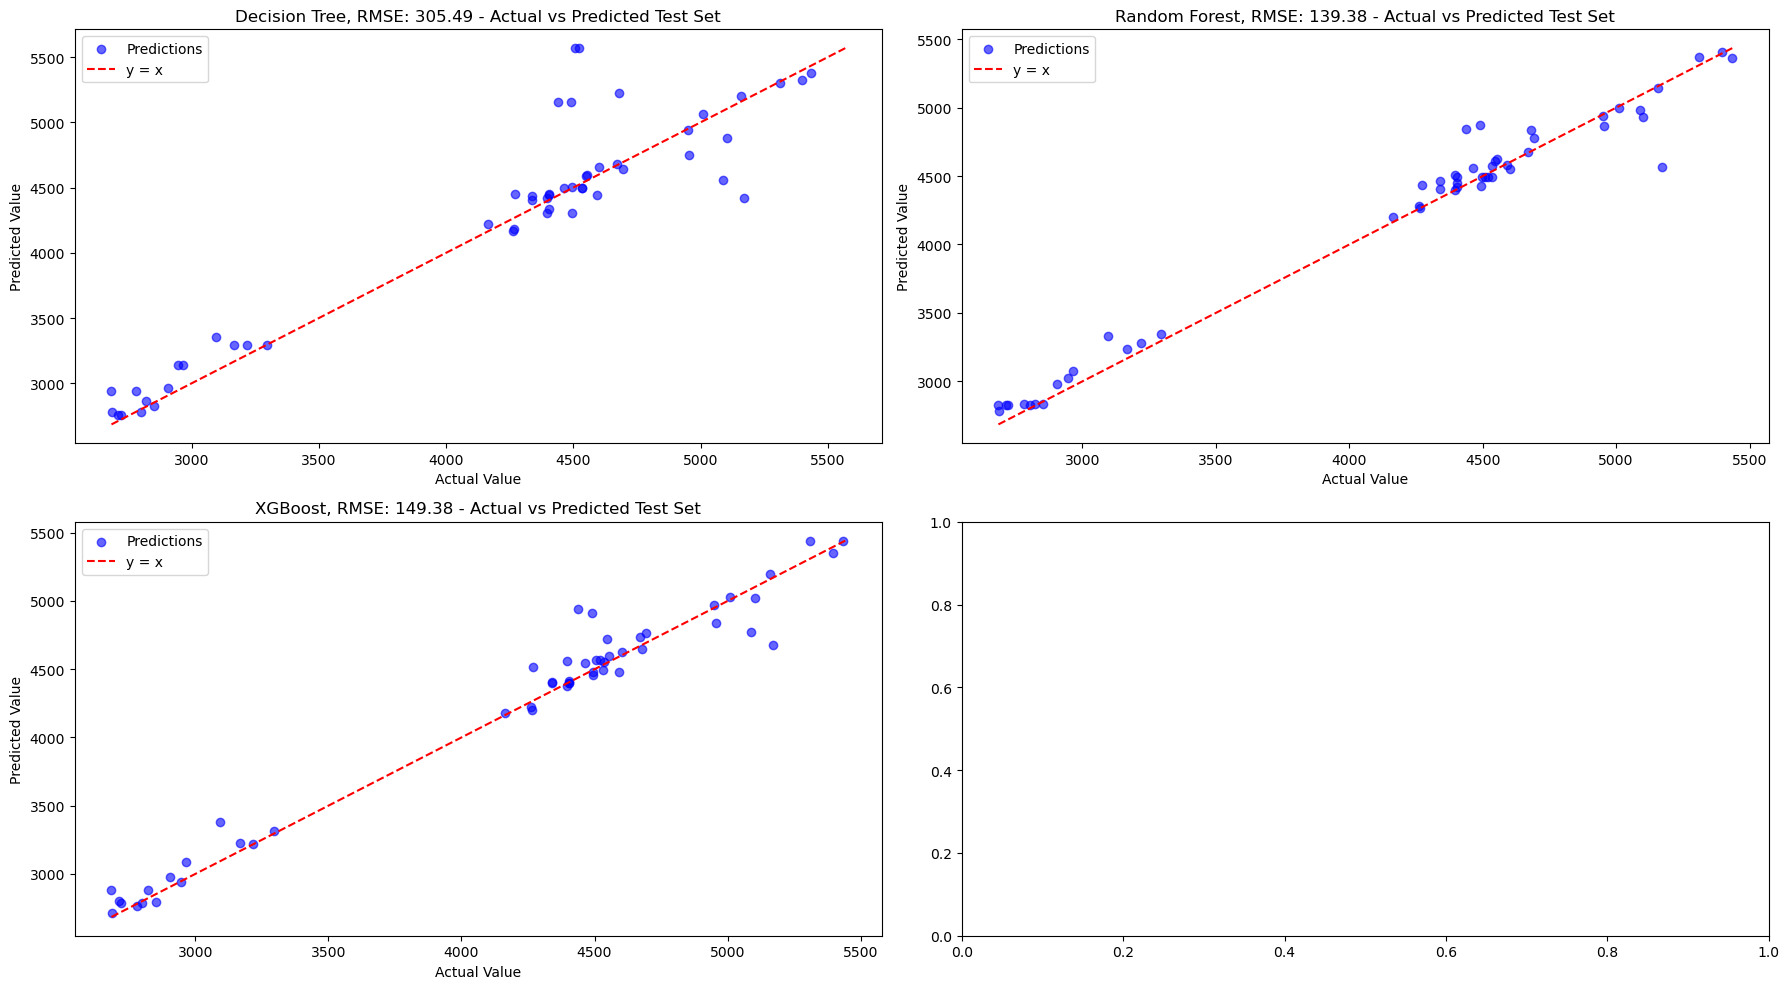

In [34]:
# Define the feature names
features = ['L', 'A', 'x0', 'b']

# Create a subplot grid (1x2)
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Flatten axes array for easier indexing
axes = axes.flatten()

# List to store RMSE values for each model
rmse_values = []

# Convert y_test to numpy for plotting
y_test_np = y_test.to_numpy()

# Fit each model, extract coefficients, and plot
for i, (name, model) in enumerate(models.items()):
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Calculate RMSE for the current model
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    rmse_values.append(rmse)

    print(model, rmse)

    # Plot Actual vs Predicted
    axes[i].scatter(y_test_np, y_pred, label='Predictions', color='blue', alpha=0.6)
    
    # Plot the "actual = predicted" line (y = x line)
    min_val = min(np.min(y_test_np), np.min(y_pred))
    max_val = max(np.max(y_test_np), np.max(y_pred))
    axes[i].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="y = x")
    
    # Set titles and labels
    axes[i].set_title(f'{name}, RMSE: {rmse.round(2)} - Actual vs Predicted Test Set')
    axes[i].set_xlabel('Actual Value')
    axes[i].set_ylabel('Predicted Value')
    axes[i].legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [35]:
# List to store percentage RMSE values
percent_rmse_values = {}

# Convert y_test to numpy for easier handling
y_test_np = y_test.to_numpy()

# Evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train_np)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    
    # Calculate percentage RMSE
    mean_actual = np.mean(y_test_np)
    percent_rmse = (rmse / mean_actual) * 100
    
    # Store the percentage RMSE
    percent_rmse_values[name] = percent_rmse

# Print out the percentage RMSE for each model
for name, percent_rmse in percent_rmse_values.items():
    print(f"{name} - Percentage RMSE: {percent_rmse:.2f}%")

Decision Tree - Percentage RMSE: 7.37%
Random Forest - Percentage RMSE: 3.36%
XGBoost - Percentage RMSE: 3.60%


In [36]:
features

['L', 'A', 'x0', 'b']

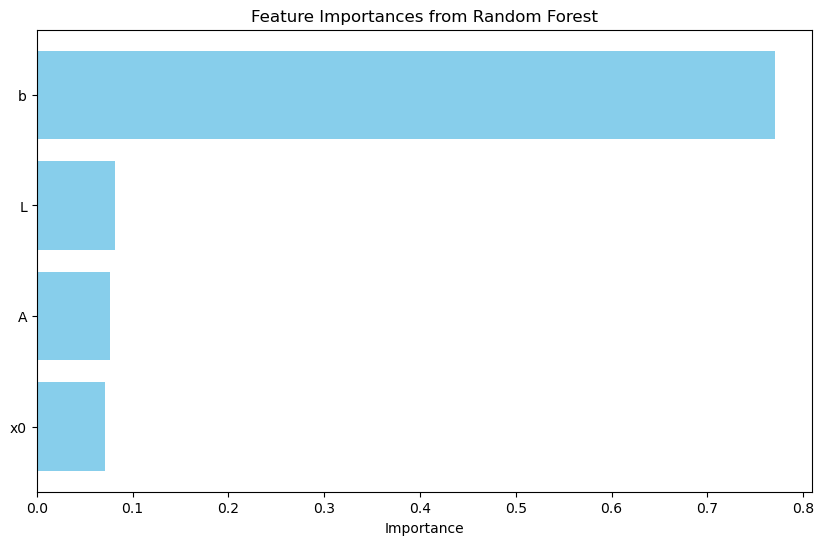

In [37]:
best_model = joblib.load('best_random_forest_model.joblib')

# Get feature importances from the model
importances = best_model.feature_importances_

# Create a DataFrame for better visualization (optional, but can make it easier to view)
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the importances by value
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.savefig('random_forest_nasa.png')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

In [38]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Load the model
best_model = joblib.load('best_decision_tree_model.joblib')

# Plot the tree
plt.figure(figsize=(20, 10))  # Adjust the size as needed
plot_tree(best_model, 
          feature_names=features,  # Replace with your feature names
          # class_names=['class1', 'class2'],  # Replace with your class names if classification
          filled=False, 
          rounded=True, 
          fontsize=10)
plt.show()

In [39]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importances')
plt.title('Feature Importances  - Best Random Forest')

# Annotate the plot with the actual coefficients
for i, (coef, feature) in enumerate(zip(importances, features)):
    plt.text(importances[i] + 0.01, i, f'{coef:.4f}', va='center')

plt.tight_layout()
plt.show()